In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [36]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)

    portfolio = np.dot(X,rweights)

    return portfolio, rweights 

In [37]:
import statsmodels.api as sm

def ols_regression(X, y):
    # Add a constant column to the X matrix
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Return the fitted values
    return results


In [38]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha):
    # Create a Ridge regression model
    model = Ridge(alpha=alpha)

    # Fit the model to the data
    model.fit(X, y)

    # Predict the target variable
    y_pred = model.predict(X)

    return y_pred

In [39]:
def compute_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [40]:
def compute_negative_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    negative_drawdown = np.min(drawdown)
    return negative_drawdown

### Tried autoencoder with cross validation on how many non communal stocks do we pick (not working) 


In [41]:
from sklearn.model_selection import TimeSeriesSplit

def autoencoder_cross_val(X, Y):
    # Prepare the data
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    Y_train, Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

    X_train_normalized = (X_train - X_train.mean()) / X_train.std()
    X_test_normalized = (X_test - X_test.mean()) / X_test.std()

    l = len(X_train_normalized[1])
    Nb_most_comm = l/10 #take care of the trend 
    folds = 5 # 5 different numbers of least communal for cross validation  
    validation_itr_train = TimeSeriesSplit(n_splits=folds).split(X_train_normalized)
    validation_itr_test = TimeSeriesSplit(n_splits=folds).split(X_test_normalized)
    score = float('inf')

    for i, (train_idx, test_idx) in enumerate(zip(validation_itr_train, validation_itr_test)):
        print(len(X_train_normalized))
        print(len(X_test_normalized))
        print(train_idx)
        print(test_idx)

        # Build the autoencoder model

        input_dim = X_train_normalized[train_idx].shape[1]

        input_layer = layers.Input(shape=(input_dim,))
        encoder = layers.Dense(30, activation='relu')(input_layer)
        decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

        autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

        # Compile and train the autoencoder
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_train_normalized[train_idx],X_train_normalized[train_idx], epochs=10, batch_size=32, validation_data=(X_test_normalized[test_idx],X_test_normalized[test_idx]))

        print(len(X_train_normalized))
        print(len(X_train_normalized))
        print(train_idx)
        print(test_idx)

        # Extract the decoded features
        decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
        decoded_features_test = decoder_model.predict(X_test_normalized)
        decod_error = abs(decoded_features_test-X_test_normalized)

        sum_of_squares = np.sum(decod_error**2, axis=0)
        print(sum_of_squares.shape)

        #CROSS VALIDATION PARAMETER 
        Nb_least_comm =  (i+1)*l/10  
        Nb_most_comm = int(Nb_most_comm)
        Nb_least_comm = int(Nb_least_comm)

        # Get the indices of the features with the smallest average decoding error
        most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

        # Get the indices of the features with the highest average decoding error
        least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

        selected_features = np.concatenate((most_comm_indices, least_comm_indices))
        #print(selected_features)
        selected_X_test_normalized = X_test_normalized[selected_features,test_idx]

        # De-normalize the selected_X_test_normalized
        selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

        # Run OLS regression
        predicted_values = ols_regression(selected_X_test_denormalized.T, Y_test[test])

        #CROSS VALIDATION 

        # Compute MSE
        mse = compute_mse(predicted_values, Y_test)
 
        # Compute negative drawdown
        negative_drawdown = compute_negative_drawdown(predicted_values)

        #SELECTION CRITERIA, MUST IMPOSE PENALTY ON NUMBER OF SELCTED FEATURES (MIGHT WANT TO ACCOUNT FOR FIXED T COSTS HERE ??)

        score_n = (mse+negative_drawdown+(mse+negative_drawdown)*(Nb_least_comm/(Nb_least_comm + Nb_most_comm)))/3

        # Check if the current score is smaller than the previous iteration score 
        if score_n < score:
            score = score_n
            Nb_least_comm_val = Nb_least_comm

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test_normalized = X_test_normalized[selected_features, :]

    # De-normalize the selected_X_test_normalized
    selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

    # Print the selected features and their shape
    print("Nb_least_comm_val:", Nb_least_comm_val)
    print("Nb_most_comm:", Nb_most_comm)
    print("Shape of selected_X_test_denormalized:", selected_X_test_denormalized.shape)

    # Return the de-normalized array
    return selected_X_test_denormalized, Nb_most_comm, Nb_least_comm_val

### Simple autoencoder

In [68]:
from tensorflow.keras import regularizers

def sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm, hidden_dim):
    # Prepare the data
    l = len(X_train.values[1])

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    #print(input_dim)

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis = 1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    #print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=40, batch_size=32, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    #print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    #print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = X_test.columns[np.argsort(sum_of_squares)[:Nb_most_comm]]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = X_test.columns[np.argsort(sum_of_squares)[-Nb_least_comm:]]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test = X_test[selected_features]
    selected_X_train = X_train[selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


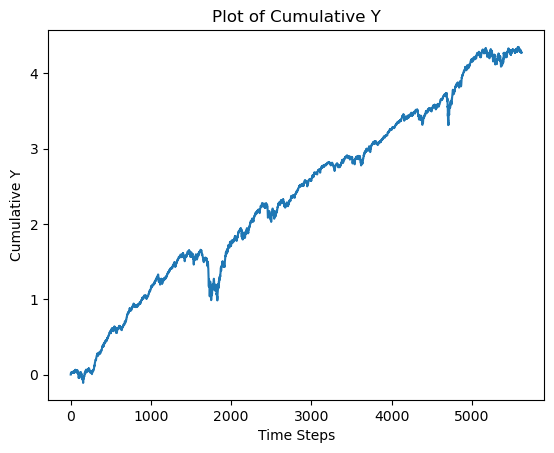

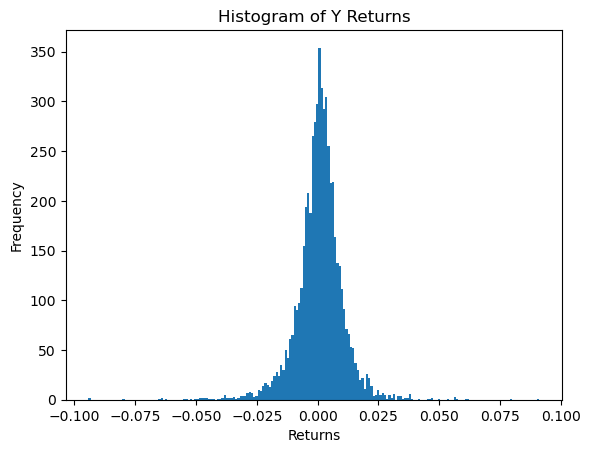

In [43]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]
returns.shape
#X = returns.iloc[:, :-900]
X = returns[returns.columns[-100:]]

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index
cumulative_y = np.cumsum(Y)

plt.plot(cumulative_y)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Y')
plt.title('Plot of Cumulative Y')
plt.show()

plt.hist(Y, bins=200)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Y Returns')
plt.show()




In [44]:
print(X.shape)
print(Y.shape)

(5621, 100)
(5621,)


In [69]:
Nb_most_comm = 10
Nb_least_com = 25
hidden_dim = 5

Epoch 1/40
141/141 [==============================] - 1s 3ms/step - loss: 0.1678 - val_loss: 0.0267
Epoch 2/40
141/141 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0010
Epoch 3/40
141/141 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.0269e-04
Epoch 4/40
141/141 [==============================] - 0s 2ms/step - loss: 7.8035e-04 - val_loss: 6.7670e-04
Epoch 5/40
141/141 [==============================] - 0s 2ms/step - loss: 6.6286e-04 - val_loss: 6.7167e-04
Epoch 6/40
141/141 [==============================] - 0s 2ms/step - loss: 6.0614e-04 - val_loss: 6.6357e-04
Epoch 7/40
141/141 [==============================] - 0s 2ms/step - loss: 5.6694e-04 - val_loss: 6.4971e-04
Epoch 8/40
141/141 [==============================] - 0s 2ms/step - loss: 5.5335e-04 - val_loss: 6.3589e-04
Epoch 9/40
141/141 [==============================] - 0s 2ms/step - loss: 5.3969e-04 - val_loss: 6.2435e-04
Epoch 10/40
141/141 [===========================

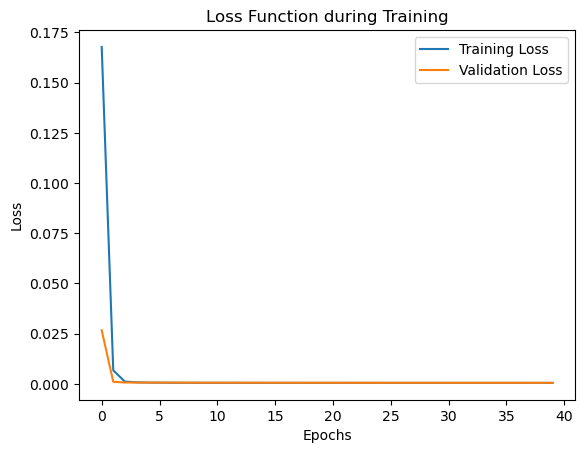

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
Res = sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_com)
history = Res[4]
# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function during Training')
plt.legend()
plt.show()


In [46]:
X

,489,3412,4010,6006,6017,6153,6185,6606,5978,6422,...,6801,6802,6803,6806,6821,6822,6823,6824,6825,6830
2002-03-06,0.006932,0.008273,0.004998,-0.040340,0.022407,0.282443,0.015157,0.055844,-0.040147,-0.000638,...,0.038855,0.004979,-0.003386,-0.007066,0.030230,-0.027764,-0.029382,0.009958,0.005976,0.004521
2002-03-07,0.008485,-0.012821,0.060707,0.022268,0.027397,0.455357,-0.009954,0.009167,0.068746,0.092516,...,-0.001098,-0.020350,-0.001699,0.025953,0.071353,-0.000985,0.021341,0.023613,-0.009862,0.003809
2002-03-08,0.011442,0.000779,0.044123,0.000222,-0.028003,0.098160,-0.001077,-0.002699,-0.031586,0.003353,...,-0.006625,-0.006983,-0.069221,0.000129,0.023661,0.039921,0.006149,0.093657,0.000000,-0.006642
2002-03-11,0.009043,0.002855,0.005530,-0.013556,0.056245,-0.009311,-0.026959,-0.005737,-0.005333,0.011494,...,-0.000369,-0.001763,0.029835,-0.005824,-0.035733,-0.033649,0.012302,-0.023487,0.004200,0.020647
2002-03-12,-0.001038,0.011646,-0.020631,-0.005181,0.025974,-0.080827,0.038050,-0.010722,-0.010315,-0.026910,...,-0.000369,0.030119,-0.023646,0.001439,0.008681,-0.041687,-0.008276,0.009019,-0.000239,-0.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,0.002254,0.003984,0.008145,0.013740,0.018502,0.030590,0.011617,0.004296,-0.030266,0.001995,...,0.011449,0.007766,0.012627,-0.027975,0.001816,0.025259,0.011543,0.029024,0.005581,0.005394
2023-09-15,-0.015444,0.000529,-0.001003,-0.013299,-0.017296,-0.003062,-0.011078,-0.000742,0.014744,-0.001326,...,-0.018352,-0.008188,-0.029646,-0.016934,0.002702,-0.050901,0.004280,-0.009271,-0.026131,-0.012850
2023-09-18,-0.019393,-0.025248,0.002767,-0.003613,-0.000443,-0.013981,-0.003552,0.001490,0.001490,0.001490,...,0.010037,-0.008984,0.009553,0.001472,-0.002217,-0.006975,-0.002417,0.016843,0.006464,0.005570
2023-09-19,0.012051,-0.016816,-0.007950,-0.008534,-0.006534,-0.007531,0.001097,-0.008252,-0.017058,0.001254,...,0.018130,-0.015068,-0.021039,-0.000899,0.004582,-0.007830,-0.013948,-0.007669,0.009919,-0.062576


(36,)


2023-07-26   -0.005039
2023-07-27    0.001378
2023-07-28    0.003211
2023-07-31    0.001681
2023-08-01   -0.005629
2023-08-02   -0.010504
2023-08-03   -0.002677
2023-08-04   -0.002388
2023-08-07    0.001534
2023-08-08   -0.007417
2023-08-09   -0.005014
2023-08-10    0.005315
2023-08-11   -0.008043
2023-08-14    0.000765
2023-08-15   -0.011180
2023-08-16   -0.009067
2023-08-17   -0.016859
2023-08-18   -0.003114
2023-08-21   -0.003202
2023-08-22    0.001879
2023-08-23    0.008683
2023-08-24   -0.013001
2023-08-25   -0.001313
2023-08-28    0.010691
2023-08-29    0.014734
2023-08-30    0.003835
2023-08-31   -0.000151
2023-09-01   -0.001560
2023-09-04    0.001011
2023-09-05   -0.014154
2023-09-06   -0.005509
2023-09-07   -0.013653
2023-09-08   -0.007357
2023-09-11    0.002579
2023-09-12   -0.005313
2023-09-13   -0.007533
2023-09-14    0.008260
2023-09-15   -0.007603
2023-09-18   -0.001887
2023-09-19   -0.007645
2023-09-20    0.002583
dtype: float64

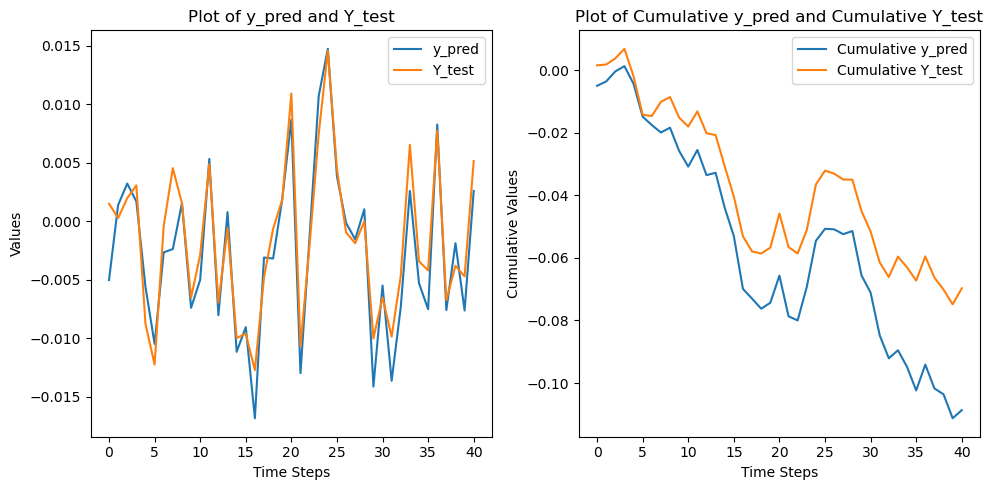

Number of selected features: 35
Tracking Error: 0.0025305724050186324


In [58]:
selected_X_test, selected_X_train, _,_, Nb_least_comm_val = Res

results = ols_regression(selected_X_train,Y_train)
coeff = results.params
print(coeff.shape)

#do regression using fitted coefficient to predict y on test set 
predicted_values = results.predict(sm.add_constant(selected_X_test))

display(predicted_values)

# Plot the predicted values and Y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(predicted_values.values, label='y_pred')
plt.plot(Y_test, label='Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Plot of y_pred and Y_test')
plt.legend()

# Compute the cumulative values
cumulative_predicted_values = np.cumsum(predicted_values.values)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test.columns))

tracking_error = np.sqrt(compute_mse(predicted_values, Y_test))
print("Tracking Error:", tracking_error)



random selection process, just to compare 



In [48]:
import random

def random_feature_selection(X, num_features):
    # Get the column names of X
    columns = X.columns.tolist()

    # Select num_features randomly from the columns
    selected_features = random.sample(columns, num_features)

    # Return the selected features
    return X[selected_features]


X_test = X[int(len(X)*0.8):]

num_iterations = 100  # Number of iterations to repeat the code block
tracking_errors = []  # List to store tracking errors

for _ in range(num_iterations):
    # Perform the same task as the previous cell
    selected_X_train_random = random_feature_selection(X_train, len(selected_X_train.columns))
    results = ols_regression(selected_X_train_random, Y_train)

    # Get the predicted values
    predicted_values_random = results.predict(sm.add_constant(X_test[selected_X_train_random.columns]))
    

    tracking_error_random = compute_mse(predicted_values_random, Y_test)
    tracking_errors.append(tracking_error_random)

mean_tracking_error = sum(tracking_errors) / len(tracking_errors)
print("Mean Average Tracking Error for random selection sample:", np.sqrt(mean_tracking_error))


Mean Average Tracking Error for random selection sample: 0.0037227599525407667


In [49]:
X

,489,3412,4010,6006,6017,6153,6185,6606,5978,6422,...,6801,6802,6803,6806,6821,6822,6823,6824,6825,6830
2002-03-06,0.006932,0.008273,0.004998,-0.040340,0.022407,0.282443,0.015157,0.055844,-0.040147,-0.000638,...,0.038855,0.004979,-0.003386,-0.007066,0.030230,-0.027764,-0.029382,0.009958,0.005976,0.004521
2002-03-07,0.008485,-0.012821,0.060707,0.022268,0.027397,0.455357,-0.009954,0.009167,0.068746,0.092516,...,-0.001098,-0.020350,-0.001699,0.025953,0.071353,-0.000985,0.021341,0.023613,-0.009862,0.003809
2002-03-08,0.011442,0.000779,0.044123,0.000222,-0.028003,0.098160,-0.001077,-0.002699,-0.031586,0.003353,...,-0.006625,-0.006983,-0.069221,0.000129,0.023661,0.039921,0.006149,0.093657,0.000000,-0.006642
2002-03-11,0.009043,0.002855,0.005530,-0.013556,0.056245,-0.009311,-0.026959,-0.005737,-0.005333,0.011494,...,-0.000369,-0.001763,0.029835,-0.005824,-0.035733,-0.033649,0.012302,-0.023487,0.004200,0.020647
2002-03-12,-0.001038,0.011646,-0.020631,-0.005181,0.025974,-0.080827,0.038050,-0.010722,-0.010315,-0.026910,...,-0.000369,0.030119,-0.023646,0.001439,0.008681,-0.041687,-0.008276,0.009019,-0.000239,-0.038405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,0.002254,0.003984,0.008145,0.013740,0.018502,0.030590,0.011617,0.004296,-0.030266,0.001995,...,0.011449,0.007766,0.012627,-0.027975,0.001816,0.025259,0.011543,0.029024,0.005581,0.005394
2023-09-15,-0.015444,0.000529,-0.001003,-0.013299,-0.017296,-0.003062,-0.011078,-0.000742,0.014744,-0.001326,...,-0.018352,-0.008188,-0.029646,-0.016934,0.002702,-0.050901,0.004280,-0.009271,-0.026131,-0.012850
2023-09-18,-0.019393,-0.025248,0.002767,-0.003613,-0.000443,-0.013981,-0.003552,0.001490,0.001490,0.001490,...,0.010037,-0.008984,0.009553,0.001472,-0.002217,-0.006975,-0.002417,0.016843,0.006464,0.005570
2023-09-19,0.012051,-0.016816,-0.007950,-0.008534,-0.006534,-0.007531,0.001097,-0.008252,-0.017058,0.001254,...,0.018130,-0.015068,-0.021039,-0.000899,0.004582,-0.007830,-0.013948,-0.007669,0.009919,-0.062576


## With rebalancing every 28 days same rolling window approach as lasso for test/training

Epoch 1/40
10/10 [==============================] - 1s 24ms/step - loss: 0.2441 - val_loss: 0.2438
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2329 - val_loss: 0.2379
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2206 - val_loss: 0.2298
Epoch 4/40
10/10 [==============================] - 0s 5ms/step - loss: 0.2069 - val_loss: 0.2189
Epoch 5/40
10/10 [==============================] - 0s 5ms/step - loss: 0.1901 - val_loss: 0.2043
Epoch 6/40
10/10 [==============================] - 0s 7ms/step - loss: 0.1711 - val_loss: 0.1848
Epoch 7/40
10/10 [==============================] - 0s 5ms/step - loss: 0.1493 - val_loss: 0.1605
Epoch 8/40
10/10 [==============================] - 0s 7ms/step - loss: 0.1259 - val_loss: 0.1319
Epoch 9/40
10/10 [==============================] - 0s 7ms/step - loss: 0.1021 - val_loss: 0.1011
Epoch 10/40
10/10 [==============================] - 0s 7ms/step - loss: 0.0786 - val_loss: 0.0719
Epoch 11/40
10/10 

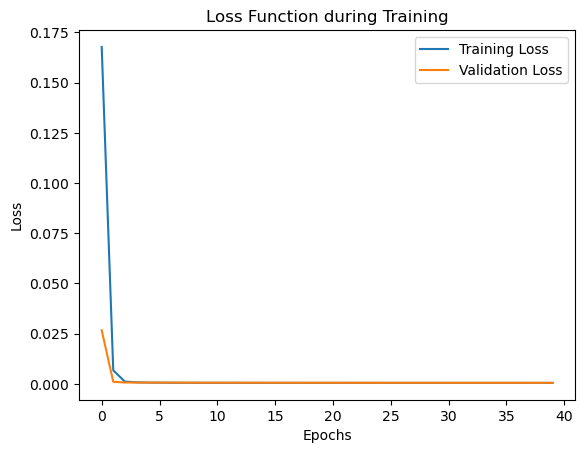

Epoch 1/40
10/10 [==============================] - 1s 16ms/step - loss: 0.2500 - val_loss: 0.2447
Epoch 2/40
10/10 [==============================] - 0s 4ms/step - loss: 0.2397 - val_loss: 0.2409
Epoch 3/40
10/10 [==============================] - 0s 4ms/step - loss: 0.2292 - val_loss: 0.2353
Epoch 4/40
10/10 [==============================] - 0s 4ms/step - loss: 0.2168 - val_loss: 0.2269
Epoch 5/40
10/10 [==============================] - 0s 4ms/step - loss: 0.2017 - val_loss: 0.2146
Epoch 6/40
10/10 [==============================] - 0s 3ms/step - loss: 0.1833 - val_loss: 0.1976
Epoch 7/40
10/10 [==============================] - 0s 4ms/step - loss: 0.1616 - val_loss: 0.1746
Epoch 8/40
10/10 [==============================] - 0s 4ms/step - loss: 0.1366 - val_loss: 0.1457
Epoch 9/40
10/10 [==============================] - 0s 4ms/step - loss: 0.1104 - val_loss: 0.1130
Epoch 10/40
10/10 [==============================] - 0s 4ms/step - loss: 0.0845 - val_loss: 0.0802
Epoch 11/40
10/10 

In [73]:
Y_pred_final_LS = []

rebalance = 60
split_index = rebalance*5

Nb_most_comm = 5
Nb_least_com = 15
hidden_dim = 10

#Nb_least_com = int(np.linspace(10, 50, 20))

#for j in Nb_least_com:
#try iterate over number of least comm features and see how trracking error goes, if seems interesting 
#might want to inlude crosse validation in the process and then adjust it dynamically



for i in range(0, X.shape[0]-split_index, rebalance):
    # split_index_here = int(0.8 * len(X.T) + i)  # Use 80% of the data for training
    split_index_here = 5*rebalance + i

    X_train, Y_train = X[(split_index_here - 5 * rebalance):split_index_here], Y[(split_index_here - 5 * rebalance):split_index_here]

    # For testing, take only 28 after split_index_here
    X_test, Y_test = X[split_index_here:(split_index_here + rebalance)], Y[split_index_here:(split_index_here + rebalance)]

    Res = sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_com, hidden_dim)

    if i == 0:
        # Plot the loss function
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Function during Training')
        plt.legend()
        plt.show()
    
    selected_X_test, selected_X_train, _,_, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train,Y_train)
    coeff = results.params

    #do regression using fitted coefficient to predict y on test set 
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    
    Y_pred_final_LS.extend(predicted_values.values)


In [ ]:
cumulative_predicted_values.shape

(5171,)

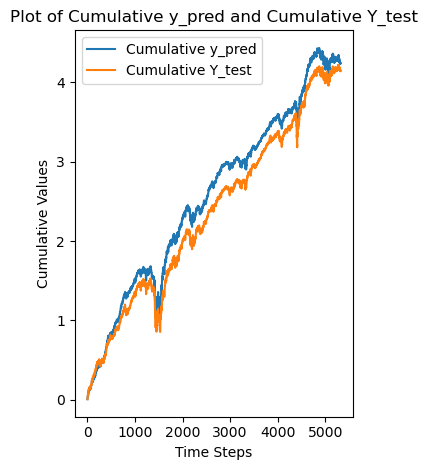

Number of selected features: 20
Tracking Error: 0.21818837161629998


In [74]:
Y_pred_final_LS
# Compute the cumulative values
cumulative_predicted_values = np.cumsum(Y_pred_final_LS)
cumulative_Y_test = np.cumsum(Y_test)
cum_returns_real = np.cumsum(Y[split_index:])

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cum_returns_real, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test.columns))

tracking_error = np.sqrt(compute_mse(cum_returns_real, cumulative_predicted_values))
print("Tracking Error:", tracking_error)